In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
from agent import Agent
import backend
import util
import dummy
import renju
import numpy
from agent import BackendAgent, HumanAgent
from renju import run, run_test, Player
import matplotlib.pyplot
import time

def choose_best(rewards, visits, probs):
    x = ((rewards > visits * 0.85) +\
            (rewards > 0.25 * visits) + (rewards / (1 + visits))\
             + 10 * probs / (1 + visits))
    return x

def one_to_two(number):
    return number // 15, number % 15

class Node():
    def __init__(self, color):
        self.children = [None for i in range(225)]
        self.n_children = 0
        self.color = color
        self.probs = np.zeros(225)
        self.visit = np.zeros(225)
        self.rewds = np.zeros(225)
        self.position = np.zeros((15, 15))

    def add_child(self, number):
        child = Node(-self.color)
        self.children[number] = child
        self.n_children += 1


class GodPlayer(Agent):
    def __init__(self, name, color, r_model, w_model, b_model):
        print("INIT_PLAYER")
        self._name = name
        self.position = np.zeros((15, 15))
        if (color == 'white'):
            self._polic = w_model[0]
            self._gpolic = w_model[1]
            self.color = -1
        else:
            self._polic = b_model[0]
            self._gpolic = b_model[1]
            self.color = 1
        self._rollout = r_model[0]
        self._grollout = r_model[1]
            
    def name(self):
        return self._name

    def deeper_pls(self):
        cur_node = self.node
        cur_deep = 0
        max_deep = 10
        cur_pose = self.position.copy()
        path = []
        reward = 0
        while (cur_deep < max_deep):
            if (cur_node.n_children == 0):
                
                with self._gpolic.as_default():
                    cur_node.probs = self._polic.predict(cur_pose.reshape(1, 15, 15, 1))
                    
                #cur_node.probs = self.polic.predict(cur_pose.reshape(1, 15, 15, 1))
                best_move_ever = np.argmax(cur_node.probs)
                x, y = one_to_two(best_move_ever)
                if (cur_deep == 0):
                    print(util.to_move([best_move_ever // 15, best_move_ever % 15]))
                cur_pose[x][y] = cur_node.color
                path.append(best_move_ever)
                cur_node.add_child(best_move_ever)
                if util.check(cur_pose, one_to_two(best_move_ever)):
                    return path, cur_node.color
                return path, self.make_rollout(cur_pose, -cur_node.color)
            else:
                best_move_ever = np.argmax(choose_best(cur_node.rewds.reshape((1, 225)),\
                                                       cur_node.visit.reshape((1, 225)), cur_node.probs))
                x, y = one_to_two(best_move_ever)
                cur_pose[x][y] = cur_node.color
                path.append(best_move_ever)
                if cur_node.visit[best_move_ever] == 0:
                    cur_node.add_child(best_move_ever)
                if util.check(cur_pose, one_to_two(best_move_ever)):
                    return path, cur_node.color
                cur_node = cur_node.children[best_move_ever]
                cur_deep += 1
        return path, reward
    
    def make_rollout(self, position, node_color):
        color = node_color
        cur_deep = 0
        max_deep = 15
        while (cur_deep < max_deep):
            with self._grollout.as_default():
                next_move = np.argmax(self._rollout.predict(position.reshape(1, 15, 15, 1)))
            
            #next_move = np.argmax(self.rollout.predict(position.reshape(1, 15, 15, 1)))
            x, y = one_to_two(next_move)
            position[x][y] = color
            if util.check(position, one_to_two(next_move)):
                return color
            color *= -1
            cur_deep += 1
        return 0
    
    def make_move(self, position):
        self.position = position
        self.node = Node(self.color)
        self.node.position = position
        start_time = time.time()
        max_time = 3.9
        while (time.time() - start_time < max_time):
            path, reward = self.deeper_pls()
            cur_node = self.node
            for move in path:
                cur_node.rewds[move] += cur_node.color * reward # Отнормировать реворды
                cur_node.visit[move] += 1
                cur_node = cur_node.children[move]
        best_move_ever = np.argmax(choose_best(self.node.rewds.reshape((1, 225)),\
                                               self.node.visit.reshape((1, 225)), self.node.probs))
        
        big_values = (self.node.visit.reshape((1, 225)) > 50) * self.node.rewds.reshape((1, 225))\
                / (1 + self.node.visit.reshape((1, 225)))
        #possible_moves = 
        if np.max(big_values) > 0.8:
            return big_values
        else:
            return self.node.visit.reshape((1, 225))
        #return one_to_two(best_move_ever) # Что надо вернуть? Буква + цифра?
        return choose_best(self.node.rewds.reshape((1, 225)), self.node.visit.reshape((1, 225)), self.node.probs)
    
    def policy(self, game):
        position = -game.board()
        arr = self.make_move(position)
        code_move = numpy.argmax(arr)
        print(self._name + ':', util.to_move([code_move // 15, code_move % 15]))
        return arr

letters = 'abcdefghjklmnop'

def make_number(string):
    number = letters.find(string[0]) * 15 + int(string[1:]) - 1
    return number

def make_string(number):
    string = letters[number // 15] + str((number % 15) + 1)
    return string

class CnnAgent(Agent):
    def __init__(self, color, name, model):
        self._name = name
        self.color = color
        self._model = model[0]
        self._graph = model[1]
        # self.model = load_model(color + '.h5')

    def name(self):
        return self._name

    def policy(self, game):
        with self._graph.as_default():
            predictions = self._model.predict(-game.board().reshape(1, 15, 15, 1))

        available = numpy.zeros((225, 1))
        positions = util.list_positions(game.board(), renju.Player.NONE)
    
        for pos in positions:
            available[pos[0] * 15 + pos[1]] = 1
        arr = predictions.T + available * 0.1

        code_move = numpy.argmax(arr)
        print(self._name + ':', util.to_move([code_move // 15, code_move % 15]))
        return arr
    
class TestAgent(Agent):
    def __init__(self, color, name, model):
        self._name = name
        self.color = color
        self._model = model
        # self.model = load_model(color + '.h5')

    def name(self):
        return self._name

    def policy(self, game):
        predictions = self._model.predict(-game.board().reshape(1, 15, 15, 1))

        available = numpy.zeros((225, 1))
        positions = util.list_positions(game.board(), renju.Player.NONE)
    
        for pos in positions:
            available[pos[0] * 15 + pos[1]] = 1
        arr = predictions.T + available * 0.1

        code_move = numpy.argmax(arr)
        print(self._name + ':', util.to_move([code_move // 15, code_move % 15]))
        return arr

/home/pan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [11]:
%matplotlib inline
%matplotlib notebook

black_model = load_model('model-2.h5')
black_model_graph = tf.get_default_graph()
white_model = load_model('model-2.h5')
white_model_graph = tf.get_default_graph()
rollout_model = load_model('rot-2-128.h5')
rollout_model_graph = tf.get_default_graph()

C:\Users\777\Anaconda3\envs\tensorflow-cpu\lib\site-packages\keras\engine\topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [63]:
model_0b = GodPlayer(color = 'black', name = 'godb', r_model = (rollout_model, rollout_model_graph),\
                     w_model = (white_model, white_model_graph),\
                     b_model = (black_model, black_model_graph))
model_0w = GodPlayer(color = 'white', name = 'godw', r_model = (black_model, black_model_graph),\
                     w_model = (white_model, white_model_graph),\
                     b_model = (black_model, black_model_graph))
model_1 = TestAgent(color = 'black', name = 'b', model = black_model)
model_2 = TestAgent(color = 'white', name = 'w', model = white_model)
# model_3 = TestAgent(color = 'black', name = 'rb', model = rollout_model)
# model_4 = TestAgent(color = 'white', name = 'rw', model = rollout_model)

INIT_PLAYER
INIT_PLAYER


<IPython.core.display.Javascript object>


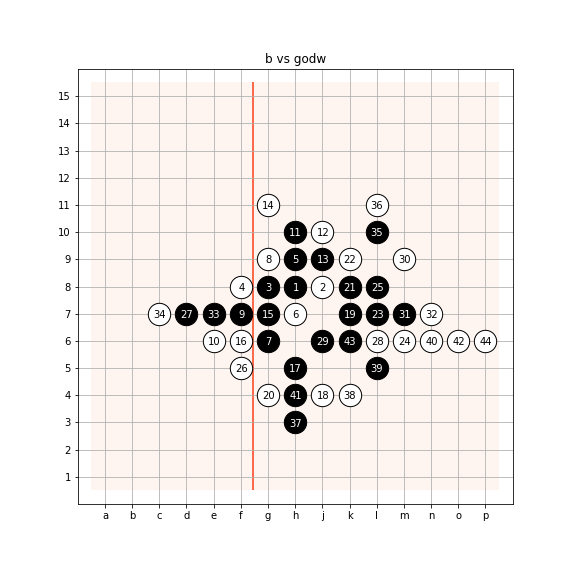

b: h8
j8
godw: j8
b: g8
f8
godw: f8
b: h9
h7
godw: h7
b: g6
g9
godw: g9
b: f7
e6
godw: e6
b: h10
j10
godw: j10
b: j9
g11
godw: g11
b: g7
f6
godw: f6
b: h5
j4
godw: j4
b: k7
g4
godw: g4
b: k8
k9
godw: k9
b: l7
m6
godw: m6
b: l8
l10
godw: f5
b: d7
e7
godw: l6
b: j6
m9
godw: m9
b: m7
n7
godw: n7
b: e7
c7
godw: c7
b: l10
l11
godw: l11
b: h3
h4
godw: k4
b: l5
h4
godw: n6
b: h4
k6
godw: o6
b: k6
p6
godw: p6


white

In [64]:
run_test(model_1, model_0w)